In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.math import argmax
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
from gym import spaces

C:\ProgramData\Miniconda3\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:39: DeprecationWar

In [2]:
rng = np.random.default_rng(358)

In [3]:
disc_actions_num = 4

In [4]:
# https://www.gymlibrary.ml/environments/box2d/lunar_lander/

In [5]:
# Using OU Noise
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()
    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x
    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

def get_actor(num_states, num_actions=1, upper_bound=1, continuous=True, layer1=400, layer2=300, 
              init_weights_min=-0.003, init_weights_max=0.003):
    last_init = tf.random_uniform_initializer(minval=init_weights_min, maxval=init_weights_max)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(layer1, activation="relu")(inputs)
    out = layers.Dense(layer2, activation="relu")(out)
    
    # Different output activation based on discrete or continous version
    if continuous:
        outputs = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)
    else:
        outputs = layers.Dense(disc_actions_num, activation="softmax", kernel_initializer=last_init)(out)

    # Multiply to fill the whole action space which should be equal around 0
    outputs = outputs * upper_bound
    return tf.keras.Model(inputs, outputs)

def get_critic(num_states, num_actions=1, continuous=True, layer1=400, layer2=300):
    state_input = layers.Input(shape=(num_states,))
    state_out = layers.Dense(32, activation="relu")(state_input)
    #state_out = layers.Dense(32, activation="relu")(state_out)

    if continuous:
        action_input = layers.Input(shape=(num_actions,))
    else:
        action_input = layers.Input(shape=(disc_actions_num,))
    action_out = layers.Dense(32, activation="relu")(action_input)

    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(layer1, activation="relu")(concat)
    out = layers.Dense(layer2, activation="relu")(out)
    outputs = layers.Dense(num_actions)(out)
#     if continuous:
#         outputs = layers.Dense(num_actions)(out)
#     else:
#         outputs = layers.Dense(disc_actions_num)(out)

    return tf.keras.Model([state_input, action_input], outputs)

# This updates the weights in a slow manner which keeps stability
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [6]:
class Agent:
    def __init__(self, num_states, num_actions=1, lower_bound=-1, upper_bound=1, continuous=True,
            buffer_capacity=50000, batch_size=64, std_dev=0.2, critic_lr=0.002,
            actor_lr=0.001, gamma=0.99, tau=0.005, epsilon=0.2, adam_critic_eps=1e-07,
            adam_actor_eps=1e-07, actor_amsgrad=False, critic_amsgrad=False, actor_layer_1=256, 
            actor_layer_2=256, critic_layer_1=256, critic_layer_2=256):
        
        self.continuous = continuous
        
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        
        # For methods
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

        # This is used to make sure we only sample from used buffer space
        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        if self.continuous:
            self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        else:
            self.action_buffer = np.zeros((self.buffer_capacity, disc_actions_num))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
        # Also keep track if it is in terminal state (legs on ground)
        self.done_buffer = np.zeros((self.buffer_capacity, 1)).astype(np.float32)
        
        self.std_dev = std_dev
        self.critic_lr = critic_lr
        self.actor_lr = actor_lr
        self.gamma = gamma
        self.tau = tau
        
        # Epsilon in epsilon-greedy
        self.epsilon = epsilon
        
        self.actor_model = get_actor(
            num_states, num_actions, upper_bound, continuous=continuous, layer1=actor_layer_1, layer2=actor_layer_2
        )
        self.critic_model = get_critic(
            num_states, num_actions, continuous=continuous, layer1=critic_layer_1, layer2=critic_layer_2
        )
        
        self.target_actor = get_actor(
            num_states, num_actions, upper_bound, continuous=continuous, layer1=actor_layer_1, layer2=actor_layer_2
        )
        self.target_critic = get_critic(
            num_states, num_actions, continuous=continuous, layer1=critic_layer_1, layer2=critic_layer_2
        )
        
        self.actor_optimizer = tf.keras.optimizers.Adam(
            learning_rate=actor_lr, beta_1=0.9, beta_2=0.999, epsilon=adam_actor_eps, amsgrad=actor_amsgrad,
        )
        self.critic_optimizer = tf.keras.optimizers.Adam(
            learning_rate=critic_lr, beta_1=0.9, beta_2=0.999, epsilon=adam_critic_eps, amsgrad=critic_amsgrad,
        )
        # Making the weights equal initially
        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())
        
        self.ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
    
    # Makes a record of the outputted (s,a,r,s') obervation tuple + terminal state
    def record(self, obs_tuple):
        # Reuse the same buffer replacing old entries
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        self.done_buffer[index] = obs_tuple[4]

        self.buffer_counter += 1
    
    # Calculation of loss and gradients
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
            # Add done_batch to y function for terminal state
            y = reward_batch + done_batch * self.gamma * self.target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = self.critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        
        # Gradient clipping to avoid exploding and vanishing gradients
        critic_gvd = zip(critic_grad, self.critic_model.trainable_variables)
        critic_capped_grad = [(tf.clip_by_value(grad, clip_value_min=-1, clip_value_max=1), var) for grad, var in critic_gvd]
        
        self.critic_optimizer.apply_gradients(critic_capped_grad)

        with tf.GradientTape() as tape:
            actions = self.actor_model(state_batch, training=True)
            critic_value = self.critic_model([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        # clip actor too
        actor_gvd = zip(actor_grad, self.actor_model.trainable_variables)
        actor_capped_grad = [(tf.clip_by_value(grad, clip_value_min=-1, clip_value_max=1), var) for grad, var in actor_gvd]
        
        self.actor_optimizer.apply_gradients(actor_capped_grad)

    def learn(self):
        # Sample only valid data
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        done_batch = tf.convert_to_tensor(self.done_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch, done_batch)
        
    def policy(self, state, noise_object=0, use_noise=True, noise_mult=1):
        # Default noise_object to 0 for when it is not needed
        # For doing actions without added noise
        if not use_noise:    
            if self.continuous:
                sampled_actions = tf.squeeze(self.actor_model(state)).numpy()
                legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)
                return [np.squeeze(legal_action)][0]
            else:
                return self.actor_model(state)
        else:
            if self.continuous:
                sampled_actions = tf.squeeze(self.actor_model(state))
                
                noise = noise_object()
                # Adding noise to action
                sampled_actions = sampled_actions.numpy() + noise * noise_mult

                # We make sure action is within bounds
                legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)
                return [np.squeeze(legal_action)][0]
            else:
                if (rng.random() < self.epsilon):
                    #random move
                    action = np.zeros(disc_actions_num)
                    action[np.random.randint(0, disc_actions_num, 1)[0]] = 1
                    return action
                else:
                    return self.actor_model(state)

In [7]:
rng.random()

0.6070693511849563

In [8]:
def fixed(x, episode):
    return x

In [9]:
def run(total_trials=1, total_episodes=100, 
            buffer_capacity=50000, batch_size=64, std_dev=0.3, critic_lr=0.003, render=False,
            actor_lr=0.002, gamma=0.99, tau=0.005, noise_mult=1, save_weights=True, 
            directory='Weights/', actor_name='actor', critic_name='critic',
            gamma_func=fixed, tau_func=fixed, critic_lr_func=fixed, actor_lr_func=fixed,
            noise_mult_func=fixed, std_dev_func=fixed, mean_number=20, output=True,
            return_rewards=False, total_time=True, use_guide=False, solved=200,
            continuous=True, environment='LunarLander-v2', seed=1453, start_steps=0,
            gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5,
            epsilon=0.2, epsilon_func=fixed, adam_critic_eps=1e-07, adam_actor_eps=1e-07,
            actor_amsgrad=False, critic_amsgrad=False, actor_layer_1=256, actor_layer_2=256,
            critic_layer_1=256, critic_layer_2=256):
    tot_time = time.time()
    
    if environment == 'LunarLander-v2':
        env = gym.make(
            "LunarLander-v2",
            continuous=continuous,
            gravity=gravity,
            enable_wind=enable_wind,
            wind_power=wind_power,
            turbulence_power=turbulence_power
        )
    else:
        env = gym.make(environment)
        
    # Apply the seed
    _ = env.reset(seed=seed)
        
    # This is needed to get the input size for the NN
    num_states = env.observation_space.low.shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')

    # This is needed to clip the actions within the legal boundaries
    upper_bound = action_space.high[0]
    lower_bound = action_space.low[0]
    
    ep_reward_list = []
    # To store average reward history of last few episodes
    avg_reward_list = []
    # To separate assisted reward structures from the "true"
    true_reward_list = []
    true_avg_reward_list = []
    
    for trial in range(total_trials):
        # Stepcount used for random start
        step = 0

        # Add sublists for each trial
        avg_reward_list.append([])
        ep_reward_list.append([])
        true_reward_list.append([])
        true_avg_reward_list.append([])
        
        agent = Agent(num_states=num_states, num_actions=num_actions, lower_bound=lower_bound, 
                upper_bound=upper_bound, continuous=continuous, buffer_capacity=buffer_capacity, 
                batch_size=batch_size, std_dev=std_dev, critic_lr=critic_lr, actor_lr=actor_lr, 
                gamma=gamma, tau=tau, epsilon=epsilon, adam_critic_eps=adam_critic_eps, adam_actor_eps=adam_actor_eps,
                actor_amsgrad=actor_amsgrad, critic_amsgrad=critic_amsgrad, actor_layer_1=actor_layer_1, 
                actor_layer_2=actor_layer_2, critic_layer_1=critic_layer_1, critic_layer_2=critic_layer_2)

        for ep in range(total_episodes):
            # functions for different parameters
            agent.gamma = gamma_func(gamma, ep)
            agent.tau = tau_func(tau, ep)
            agent.critic_lr = critic_lr_func(critic_lr, ep)
            agent.actor_lr = actor_lr_func(actor_lr, ep)
            agent.noise_mult = noise_mult_func(noise_mult, ep)
            agent.std_dev = std_dev_func(std_dev, ep)
            agent.epsilon = epsilon_func(epsilon, ep)
            
            # Used for time benchmarking
            before = time.time()

            prev_state = env.reset()
            episodic_reward = 0
            true_reward = 0

            while True:
                if render:
                    env.render()
                
                tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

                if step >= start_steps:
                    action = agent.policy(state=tf_prev_state, noise_object=agent.ou_noise, noise_mult=noise_mult)
                else:
                    action = env.action_space.sample()
                
                step += 1
                
                # Recieve state and reward from environment.
                if continuous:
                    state, reward, done, info = env.step(action)
                else:
                    state, reward, done, info = env.step(np.argmax(action))
                
                # Add this before eventual reward modification
                true_reward += reward
                
                # Reward modification
                if use_guide:
                    # giving penalty for straying far from flags and having high speed
                    # x max
#                     reward -= int(abs(state[0]) > 0.15) * 2 * abs(state[0])
#                     # y top
#                     reward -= int(state[1] > 1) * state[1] / 2
#                     # horizontal speed
#                     reward -= int(abs(state[2]) > 1) * abs(state[2])
#                     # down speed
#                     reward -= int(state[3] <  -1) * abs(state[3])
#                     # up speed
#                     reward -= int(state[3] > 0.1) * 3 * state[3]
                    reward -= abs(state[2]/2) + abs(state[3]) + (abs(state[0])) + (abs(state[1])/2)

                # Add terminal state for when it has landed. Just look at legs on the ground.
                terminal_state = int(not (state[6] and state[7]))
                agent.record((prev_state, action, reward, state, terminal_state))
                episodic_reward += reward

                agent.learn()
                update_target(agent.target_actor.variables, agent.actor_model.variables, agent.tau)
                update_target(agent.target_critic.variables, agent.critic_model.variables, agent.tau)

                if done:
                    break

                prev_state = state

            ep_reward_list[trial].append(episodic_reward)
            true_reward_list[trial].append(true_reward)
            
            avg_reward = np.mean(ep_reward_list[trial][-mean_number:])
            avg_reward_list[trial].append(avg_reward)
            true_avg_reward = np.mean(true_reward_list[trial][-mean_number:])
            true_avg_reward_list[trial].append(true_avg_reward)
            
            if output:
                print("Ep {} * AvgReward {:.2f} * true AvgReward {:.2f} * Reward {:.2f} * True Reward {:.2f} * time {:.2f} * step {}"
                  .format(ep, avg_reward, true_avg_reward, episodic_reward, 
                          true_reward, (time.time() - before), step))
            
            # Stop if avg is above 'solved'
            if true_avg_reward >= solved:
                break

        # Save weights
        now = datetime.datetime.now()
        timestamp = "{}.{}.{}.{}.{}.{}".format(now.year, now.month, now.day, now.hour, now.minute, now.second)
        save_name = "{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format(
            environment, total_episodes, 
            buffer_capacity, batch_size, 
            std_dev, critic_lr, actor_lr, 
            gamma, tau, noise_mult, 
            gamma_func.__name__, tau_func.__name__, 
            critic_lr_func.__name__, actor_lr_func.__name__, 
            noise_mult_func.__name__, std_dev_func.__name__, 
            mean_number, use_guide, 
            solved, continuous, 
            start_steps, gravity, 
            enable_wind, wind_power,
            turbulence_power, 
            epsilon, epsilon_func.__name__,
            adam_critic_eps, adam_actor_eps,
            actor_amsgrad, critic_amsgrad,
            actor_layer_1, actor_layer_2,
            critic_layer_1, critic_layer_2,
            timestamp,
        )
        if save_weights:
            try:
                agent.actor_model.save_weights(directory + actor_name + '-trial' + str(trial) + '_' + save_name + '.h5')
            except:
                print('actor save fail')
            try:
                agent.critic_model.save_weights(directory + critic_name + '-trial' + str(trial) + '_' + save_name + '.h5')
            except:
                print('critic save fail')
    
    # Plotting graph
    for idx, p in enumerate(true_avg_reward_list):
        plt.plot(p, label=str(idx))
    plt.xlabel("Episode")
    plt.ylabel("True Avg. Epsiodic Reward (" + str(mean_number) + ")")
    plt.legend()
    plt.savefig('Graphs/' + save_name + '.png')
    plt.show()
    
    print('total time:', time.time() - tot_time, 's')
    
    # Return to be able to make graphs etc. later, or use the data for other stuff
    if return_rewards:
        return true_reward_list

In [10]:
def test(total_episodes=10, actor_weights='Weights/actor-trial0.h5', render=False,
        environment="LunarLander-v2", continuous=True, gravity=-10.0, enable_wind=False,
        wind_power=15.0, turbulence_power=1.5, seed=1453):
    rewards = []
    
    env = gym.make(
        environment,
        continuous=continuous,
        gravity=gravity,
        enable_wind=enable_wind,
        wind_power=wind_power,
        turbulence_power=turbulence_power
    )
    
    # This is needed to get the input size for the NN
    num_states = env.observation_space.low.shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')

    # This is needed to clip the actions within the legal boundaries
    upper_bound = action_space.high[0]
    lower_bound = action_space.low[0]
    
    # Apply the seed
    _ = env.reset(seed=seed)
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        # Used for time benchmarking
        before = time.time()
        
        prev_state = env.reset()
        agent = Agent(num_states=num_states, num_actions=num_actions, lower_bound=lower_bound, 
                upper_bound=upper_bound, continuous=continuous, buffer_capacity=0, batch_size=0, 
                std_dev=0, critic_lr=0, actor_lr=0, gamma=0, tau=0, epsilon=0)
        agent.actor_model.load_weights(actor_weights)
        
        while True:
            if render:
                env.render()

            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

            action = agent.policy(state=tf_prev_state, use_noise=False)

            state, reward, done, _ = env.step(action)
            
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

In [11]:
def random(total_episodes=10, render=False, environment="LunarLander-v2", continuous=True,
        gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5, seed=1453):
    
    rewards = []
    
    env = gym.make(
        environment,
        continuous=continuous,
        gravity=gravity,
        enable_wind=enable_wind,
        wind_power=wind_power,
        turbulence_power=turbulence_power,
    )
    
    # Apply the seed
    _ = env.reset(seed=seed)
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        before = time.time()
        
        prev_state = env.reset()
        
        while True:
            if render:
                env.render()
            action = env.action_space.sample()
            state, reward, done, _ = env.step(action)
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

---
# Runs and tests
---

In [12]:
xax = [x for x in range(-600,250)]

In [13]:
def decreasing_std(x, episode):
    return max(0, min(0.2, 0.2 - (x+500)*(0.2/700)))

In [14]:
def decreasing_alr(x, episode):
    return max(0, min(0.001, 0.001 - (x+500)*(0.001/700)))

In [15]:
def decreasing_clr(x, episode):
    return max(0, min(0.002, 0.002 - (x+500)*(0.002/700)))

In [16]:
def decreasing_eps(x, episode):
    return max(0, min(0.3, 0.3 - (x+500)*(0.3/700)))

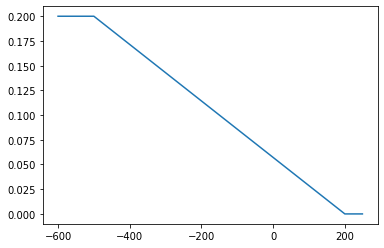

In [17]:
plt.plot(xax,[decreasing_std(x,1) for x in range(-600,250)])

In [18]:
#run(total_trials=2, total_episodes=2000, buffer_capacity=300000, tau=0.002, critic_lr=0.0003, 
#    actor_lr=0.0002, start_steps=10000, continuous=True)

In [19]:
# run(total_trials=2, total_episodes=3000, buffer_capacity=25000, tau=0.001, critic_lr=0.0002, 
#     actor_lr=0.0001, start_steps=40000, continuous=False, std_dev_func=decreasing_std, actor_lr_func=decreasing_alr,
#     critic_lr_func=decreasing_clr, epsilon_func=decreasing_eps)

In [20]:
#test(render=True, continuous=False, actor_weights='Weights/actor-trial0_LunarLander-v2_500_20000_64_0.3_0.0002_0.0001_0.99_0.001_1_fixed_fixed_fixed_fixed_fixed_fixed_20_False_200_False_5000_-10.0_False_15.0_1.5_0.2.h5')

C:\ProgramData\Miniconda3\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


Ep 0 * AvgReward -136.86 * true AvgReward -136.86 * Reward -136.86 * True Reward -136.86 * time 1.39 * step 81
Ep 1 * AvgReward -144.18 * true AvgReward -144.18 * Reward -151.49 * True Reward -151.49 * time 0.38 * step 157
Ep 2 * AvgReward -144.49 * true AvgReward -144.49 * Reward -145.11 * True Reward -145.11 * time 0.38 * step 229
Ep 3 * AvgReward -119.67 * true AvgReward -119.67 * Reward -45.21 * True Reward -45.21 * time 0.36 * step 299
Ep 4 * AvgReward -92.41 * true AvgReward -92.41 * Reward 16.64 * True Reward 16.64 * time 0.40 * step 377
Ep 5 * AvgReward -92.87 * true AvgReward -92.87 * Reward -95.20 * True Reward -95.20 * time 0.29 * step 433
Ep 6 * AvgReward -100.00 * true AvgReward -100.00 * Reward -142.75 * True Reward -142.75 * time 0.42 * step 516
Ep 7 * AvgReward -102.90 * true AvgReward -102.90 * Reward -123.19 * True Reward -123.19 * time 0.36 * step 585
Ep 8 * AvgReward -103.94 * true AvgReward -103.94 * Reward -112.32 * True Reward -112.32 * time 0.30 * step 643
Ep 9 

Ep 73 * AvgReward -140.91 * true AvgReward -140.91 * Reward -202.65 * True Reward -202.65 * time 0.51 * step 5405
Ep 74 * AvgReward -141.49 * true AvgReward -141.49 * Reward -196.78 * True Reward -196.78 * time 0.59 * step 5494
Ep 75 * AvgReward -134.44 * true AvgReward -134.44 * Reward -36.92 * True Reward -36.92 * time 0.63 * step 5589
Ep 76 * AvgReward -149.70 * true AvgReward -149.70 * Reward -299.46 * True Reward -299.46 * time 0.46 * step 5658
Ep 77 * AvgReward -151.06 * true AvgReward -151.06 * Reward -250.71 * True Reward -250.71 * time 0.46 * step 5722
Ep 78 * AvgReward -159.69 * true AvgReward -159.69 * Reward -217.98 * True Reward -217.98 * time 0.41 * step 5778
Ep 79 * AvgReward -157.84 * true AvgReward -157.84 * Reward -142.08 * True Reward -142.08 * time 0.66 * step 5867
Ep 80 * AvgReward -161.57 * true AvgReward -161.57 * Reward -193.80 * True Reward -193.80 * time 0.41 * step 5922
Ep 81 * AvgReward -166.34 * true AvgReward -166.34 * Reward -223.51 * True Reward -223.51 

Ep 145 * AvgReward -125.87 * true AvgReward -125.87 * Reward -92.14 * True Reward -92.14 * time 0.67 * step 10885
Ep 146 * AvgReward -122.68 * true AvgReward -122.68 * Reward -99.04 * True Reward -99.04 * time 0.70 * step 10986
Ep 147 * AvgReward -121.69 * true AvgReward -121.69 * Reward -114.40 * True Reward -114.40 * time 1.89 * step 11254
Ep 148 * AvgReward -130.77 * true AvgReward -130.77 * Reward -318.69 * True Reward -318.69 * time 0.72 * step 11360
Ep 149 * AvgReward -135.12 * true AvgReward -135.12 * Reward -263.03 * True Reward -263.03 * time 0.54 * step 11440
Ep 150 * AvgReward -135.69 * true AvgReward -135.69 * Reward -156.00 * True Reward -156.00 * time 0.62 * step 11530
Ep 151 * AvgReward -133.86 * true AvgReward -133.86 * Reward -88.81 * True Reward -88.81 * time 1.65 * step 11768
Ep 152 * AvgReward -136.46 * true AvgReward -136.46 * Reward -184.75 * True Reward -184.75 * time 0.61 * step 11852
Ep 153 * AvgReward -134.69 * true AvgReward -134.69 * Reward -151.33 * True Re

Ep 217 * AvgReward -105.93 * true AvgReward -105.93 * Reward -111.96 * True Reward -111.96 * time 3.98 * step 27790
Ep 218 * AvgReward -101.73 * true AvgReward -101.73 * Reward -70.02 * True Reward -70.02 * time 1.27 * step 27971
Ep 219 * AvgReward -105.09 * true AvgReward -105.09 * Reward -173.94 * True Reward -173.94 * time 6.04 * step 28746
Ep 220 * AvgReward -100.56 * true AvgReward -100.56 * Reward -15.73 * True Reward -15.73 * time 8.21 * step 29746
Ep 221 * AvgReward -96.32 * true AvgReward -96.32 * Reward -43.62 * True Reward -43.62 * time 7.89 * step 30746
Ep 222 * AvgReward -107.71 * true AvgReward -107.71 * Reward -231.45 * True Reward -231.45 * time 7.60 * step 31714
Ep 223 * AvgReward -108.36 * true AvgReward -108.36 * Reward -49.83 * True Reward -49.83 * time 7.73 * step 32714
Ep 224 * AvgReward -113.18 * true AvgReward -113.18 * Reward -103.90 * True Reward -103.90 * time 7.48 * step 33714
Ep 225 * AvgReward -111.68 * true AvgReward -111.68 * Reward -147.41 * True Reward

Ep 289 * AvgReward -96.14 * true AvgReward -96.14 * Reward -128.82 * True Reward -128.82 * time 1.08 * step 59788
Ep 290 * AvgReward -98.76 * true AvgReward -98.76 * Reward -206.26 * True Reward -206.26 * time 0.83 * step 59898
Ep 291 * AvgReward -104.53 * true AvgReward -104.53 * Reward -193.95 * True Reward -193.95 * time 0.83 * step 60014
Ep 292 * AvgReward -104.03 * true AvgReward -104.03 * Reward 11.36 * True Reward 11.36 * time 0.99 * step 60150
Ep 293 * AvgReward -97.08 * true AvgReward -97.08 * Reward 177.34 * True Reward 177.34 * time 5.30 * step 60833
Ep 294 * AvgReward -94.19 * true AvgReward -94.19 * Reward -113.90 * True Reward -113.90 * time 1.51 * step 61034
Ep 295 * AvgReward -92.71 * true AvgReward -92.71 * Reward -98.50 * True Reward -98.50 * time 1.41 * step 61225
Ep 296 * AvgReward -84.19 * true AvgReward -84.19 * Reward 87.79 * True Reward 87.79 * time 5.24 * step 61902
Ep 297 * AvgReward -87.47 * true AvgReward -87.47 * Reward -201.79 * True Reward -201.79 * time 

Ep 364 * AvgReward 50.39 * true AvgReward 50.39 * Reward -41.49 * True Reward -41.49 * time 0.98 * step 72846
Ep 365 * AvgReward 51.98 * true AvgReward 51.98 * Reward 28.13 * True Reward 28.13 * time 0.89 * step 72970
Ep 366 * AvgReward 61.42 * true AvgReward 61.42 * Reward 187.06 * True Reward 187.06 * time 7.96 * step 73962
Ep 367 * AvgReward 58.19 * true AvgReward 58.19 * Reward -45.99 * True Reward -45.99 * time 1.30 * step 74135
Ep 368 * AvgReward 59.31 * true AvgReward 59.31 * Reward 12.35 * True Reward 12.35 * time 0.87 * step 74254
Ep 369 * AvgReward 61.17 * true AvgReward 61.17 * Reward 44.96 * True Reward 44.96 * time 0.82 * step 74369
Ep 370 * AvgReward 59.47 * true AvgReward 59.47 * Reward -4.56 * True Reward -4.56 * time 1.00 * step 74507
Ep 371 * AvgReward 48.59 * true AvgReward 48.59 * Reward 11.48 * True Reward 11.48 * time 1.07 * step 74656
Ep 372 * AvgReward 47.24 * true AvgReward 47.24 * Reward -14.59 * True Reward -14.59 * time 1.08 * step 74805
Ep 373 * AvgReward 4

Ep 438 * AvgReward -11.42 * true AvgReward -11.42 * Reward -39.18 * True Reward -39.18 * time 9.03 * step 98195
Ep 439 * AvgReward -4.36 * true AvgReward -4.36 * Reward -51.64 * True Reward -51.64 * time 9.00 * step 99195
Ep 440 * AvgReward 3.90 * true AvgReward 3.90 * Reward -18.79 * True Reward -18.79 * time 2.84 * step 99563
Ep 441 * AvgReward 12.84 * true AvgReward 12.84 * Reward -7.63 * True Reward -7.63 * time 9.39 * step 100563
Ep 442 * AvgReward 21.48 * true AvgReward 21.48 * Reward 0.60 * True Reward 0.60 * time 8.61 * step 101563
Ep 443 * AvgReward 29.45 * true AvgReward 29.45 * Reward 29.31 * True Reward 29.31 * time 1.99 * step 101815
Ep 444 * AvgReward 32.52 * true AvgReward 32.52 * Reward -11.17 * True Reward -11.17 * time 1.48 * step 101956
Ep 445 * AvgReward 38.90 * true AvgReward 38.90 * Reward 67.46 * True Reward 67.46 * time 1.57 * step 102149
Ep 446 * AvgReward 29.02 * true AvgReward 29.02 * Reward -22.98 * True Reward -22.98 * time 1.26 * step 102267
Ep 447 * AvgRe

Ep 513 * AvgReward 33.61 * true AvgReward 33.61 * Reward -30.24 * True Reward -30.24 * time 0.77 * step 115291
Ep 514 * AvgReward 30.71 * true AvgReward 30.71 * Reward -18.63 * True Reward -18.63 * time 1.13 * step 115441
Ep 515 * AvgReward 19.93 * true AvgReward 19.93 * Reward -16.21 * True Reward -16.21 * time 0.72 * step 115535
Ep 516 * AvgReward 19.29 * true AvgReward 19.29 * Reward 4.17 * True Reward 4.17 * time 0.93 * step 115659
Ep 517 * AvgReward 17.69 * true AvgReward 17.69 * Reward -30.32 * True Reward -30.32 * time 0.60 * step 115741
Ep 518 * AvgReward 19.33 * true AvgReward 19.33 * Reward 42.93 * True Reward 42.93 * time 0.87 * step 115857
Ep 519 * AvgReward 18.00 * true AvgReward 18.00 * Reward -24.82 * True Reward -24.82 * time 0.71 * step 115953
Ep 520 * AvgReward 19.71 * true AvgReward 19.71 * Reward 29.45 * True Reward 29.45 * time 0.69 * step 116047
Ep 521 * AvgReward 19.23 * true AvgReward 19.23 * Reward -32.93 * True Reward -32.93 * time 0.66 * step 116138
Ep 522 * 

Ep 588 * AvgReward 3.46 * true AvgReward 3.46 * Reward -5.75 * True Reward -5.75 * time 1.05 * step 124972
Ep 589 * AvgReward 3.37 * true AvgReward 3.37 * Reward -5.88 * True Reward -5.88 * time 0.99 * step 125100
Ep 590 * AvgReward 3.88 * true AvgReward 3.88 * Reward 29.97 * True Reward 29.97 * time 0.74 * step 125202
Ep 591 * AvgReward 5.47 * true AvgReward 5.47 * Reward 35.88 * True Reward 35.88 * time 1.04 * step 125338
Ep 592 * AvgReward 8.49 * true AvgReward 8.49 * Reward 21.90 * True Reward 21.90 * time 0.95 * step 125464
Ep 593 * AvgReward -1.33 * true AvgReward -1.33 * Reward 5.80 * True Reward 5.80 * time 0.97 * step 125595
Ep 594 * AvgReward 2.09 * true AvgReward 2.09 * Reward -2.93 * True Reward -2.93 * time 1.13 * step 125746
Ep 595 * AvgReward -0.52 * true AvgReward -0.52 * Reward -10.21 * True Reward -10.21 * time 0.98 * step 125874
Ep 596 * AvgReward 11.28 * true AvgReward 11.28 * Reward 266.05 * True Reward 266.05 * time 1.67 * step 126097
Ep 597 * AvgReward 10.70 * tr

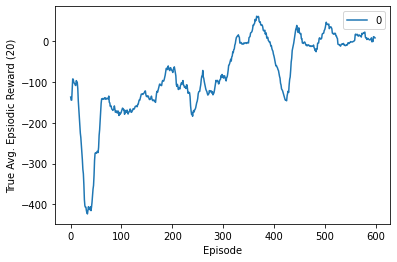

total time: 977.1152210235596 s


In [21]:
run(total_trials=1, total_episodes=600, buffer_capacity=200000, tau=0.0005, critic_lr=0.0001, 
    actor_lr=0.00005, start_steps=1000, continuous=False, epsilon_func=decreasing_eps)

Ep 0 * AvgReward -136.86 * true AvgReward -136.86 * Reward -136.86 * True Reward -136.86 * time 0.90 * step 81
Ep 1 * AvgReward -144.18 * true AvgReward -144.18 * Reward -151.49 * True Reward -151.49 * time 0.35 * step 157
Ep 2 * AvgReward -144.49 * true AvgReward -144.49 * Reward -145.11 * True Reward -145.11 * time 0.34 * step 229
Ep 3 * AvgReward -119.67 * true AvgReward -119.67 * Reward -45.21 * True Reward -45.21 * time 0.32 * step 299
Ep 4 * AvgReward -92.41 * true AvgReward -92.41 * Reward 16.64 * True Reward 16.64 * time 0.37 * step 377
Ep 5 * AvgReward -92.87 * true AvgReward -92.87 * Reward -95.20 * True Reward -95.20 * time 0.27 * step 433
Ep 6 * AvgReward -100.00 * true AvgReward -100.00 * Reward -142.75 * True Reward -142.75 * time 0.42 * step 516
Ep 7 * AvgReward -102.90 * true AvgReward -102.90 * Reward -123.19 * True Reward -123.19 * time 0.35 * step 585
Ep 8 * AvgReward -103.94 * true AvgReward -103.94 * Reward -112.32 * True Reward -112.32 * time 0.28 * step 643
Ep 9 

Ep 73 * AvgReward -180.94 * true AvgReward -180.94 * Reward -306.81 * True Reward -306.81 * time 0.81 * step 7167
Ep 74 * AvgReward -185.68 * true AvgReward -185.68 * Reward -214.83 * True Reward -214.83 * time 0.72 * step 7271
Ep 75 * AvgReward -199.77 * true AvgReward -199.77 * Reward -387.81 * True Reward -387.81 * time 0.84 * step 7387
Ep 76 * AvgReward -214.28 * true AvgReward -214.28 * Reward -302.24 * True Reward -302.24 * time 0.71 * step 7487
Ep 77 * AvgReward -231.51 * true AvgReward -231.51 * Reward -205.47 * True Reward -205.47 * time 0.72 * step 7589
Ep 78 * AvgReward -237.37 * true AvgReward -237.37 * Reward -294.89 * True Reward -294.89 * time 0.73 * step 7690
Ep 79 * AvgReward -240.48 * true AvgReward -240.48 * Reward -246.68 * True Reward -246.68 * time 1.33 * step 7874
Ep 80 * AvgReward -243.53 * true AvgReward -243.53 * Reward -321.97 * True Reward -321.97 * time 0.80 * step 7983
Ep 81 * AvgReward -249.63 * true AvgReward -249.63 * Reward -352.71 * True Reward -352.7

Ep 145 * AvgReward -416.15 * true AvgReward -416.15 * Reward -492.16 * True Reward -492.16 * time 0.68 * step 26032
Ep 146 * AvgReward -409.04 * true AvgReward -409.04 * Reward -288.12 * True Reward -288.12 * time 0.51 * step 26101
Ep 147 * AvgReward -396.88 * true AvgReward -396.88 * Reward -288.08 * True Reward -288.08 * time 0.54 * step 26175
Ep 148 * AvgReward -393.27 * true AvgReward -393.27 * Reward -351.71 * True Reward -351.71 * time 0.66 * step 26249
Ep 149 * AvgReward -399.77 * true AvgReward -399.77 * Reward -459.66 * True Reward -459.66 * time 0.64 * step 26337
Ep 150 * AvgReward -393.99 * true AvgReward -393.99 * Reward -369.02 * True Reward -369.02 * time 0.69 * step 26428
Ep 151 * AvgReward -392.86 * true AvgReward -392.86 * Reward -313.27 * True Reward -313.27 * time 0.88 * step 26544
Ep 152 * AvgReward -390.04 * true AvgReward -390.04 * Reward -363.86 * True Reward -363.86 * time 0.58 * step 26625
Ep 153 * AvgReward -385.97 * true AvgReward -385.97 * Reward -309.59 * T

Ep 217 * AvgReward -84.90 * true AvgReward -84.90 * Reward 18.94 * True Reward 18.94 * time 1.84 * step 52867
Ep 218 * AvgReward -92.79 * true AvgReward -92.79 * Reward -150.19 * True Reward -150.19 * time 0.88 * step 52982
Ep 219 * AvgReward -91.42 * true AvgReward -91.42 * Reward -68.37 * True Reward -68.37 * time 1.70 * step 53200
Ep 220 * AvgReward -92.60 * true AvgReward -92.60 * Reward -48.23 * True Reward -48.23 * time 2.31 * step 53494
Ep 221 * AvgReward -96.52 * true AvgReward -96.52 * Reward -159.99 * True Reward -159.99 * time 0.82 * step 53602
Ep 222 * AvgReward -100.77 * true AvgReward -100.77 * Reward -147.44 * True Reward -147.44 * time 0.86 * step 53712
Ep 223 * AvgReward -98.90 * true AvgReward -98.90 * Reward -73.83 * True Reward -73.83 * time 1.79 * step 53929
Ep 224 * AvgReward -96.52 * true AvgReward -96.52 * Reward -74.69 * True Reward -74.69 * time 1.94 * step 54176
Ep 225 * AvgReward -97.76 * true AvgReward -97.76 * Reward -151.81 * True Reward -151.81 * time 1.

Ep 291 * AvgReward -105.87 * true AvgReward -105.87 * Reward -93.05 * True Reward -93.05 * time 3.90 * step 74474
Ep 292 * AvgReward -100.37 * true AvgReward -100.37 * Reward 7.93 * True Reward 7.93 * time 2.35 * step 74768
Ep 293 * AvgReward -108.64 * true AvgReward -108.64 * Reward -316.14 * True Reward -316.14 * time 4.92 * step 75330
Ep 294 * AvgReward -98.18 * true AvgReward -98.18 * Reward 141.16 * True Reward 141.16 * time 4.03 * step 75833
Ep 295 * AvgReward -103.66 * true AvgReward -103.66 * Reward -305.81 * True Reward -305.81 * time 4.34 * step 76354
Ep 296 * AvgReward -87.27 * true AvgReward -87.27 * Reward 186.72 * True Reward 186.72 * time 4.10 * step 76847
Ep 297 * AvgReward -70.06 * true AvgReward -70.06 * Reward 185.12 * True Reward 185.12 * time 4.81 * step 77414
Ep 298 * AvgReward -64.37 * true AvgReward -64.37 * Reward -33.57 * True Reward -33.57 * time 1.04 * step 77549
Ep 299 * AvgReward -79.95 * true AvgReward -79.95 * Reward -102.51 * True Reward -102.51 * time 

Ep 363 * AvgReward 13.25 * true AvgReward 13.25 * Reward -89.89 * True Reward -89.89 * time 2.20 * step 104858
Ep 364 * AvgReward 30.03 * true AvgReward 30.03 * Reward 189.28 * True Reward 189.28 * time 2.74 * step 105202
Ep 365 * AvgReward 33.00 * true AvgReward 33.00 * Reward 191.11 * True Reward 191.11 * time 2.91 * step 105566
Ep 366 * AvgReward 32.54 * true AvgReward 32.54 * Reward 193.71 * True Reward 193.71 * time 3.98 * step 106044
Ep 367 * AvgReward 43.63 * true AvgReward 43.63 * Reward 188.40 * True Reward 188.40 * time 2.56 * step 106358
Ep 368 * AvgReward 41.89 * true AvgReward 41.89 * Reward 84.30 * True Reward 84.30 * time 8.35 * step 107358
Ep 369 * AvgReward 53.72 * true AvgReward 53.72 * Reward 161.28 * True Reward 161.28 * time 3.55 * step 107801
Ep 370 * AvgReward 63.16 * true AvgReward 63.16 * Reward 168.87 * True Reward 168.87 * time 2.59 * step 108125
Ep 371 * AvgReward 64.48 * true AvgReward 64.48 * Reward 145.31 * True Reward 145.31 * time 3.17 * step 108506
Ep 

Ep 436 * AvgReward -178.78 * true AvgReward -178.78 * Reward -97.93 * True Reward -97.93 * time 9.09 * step 160463
Ep 437 * AvgReward -165.36 * true AvgReward -165.36 * Reward -194.54 * True Reward -194.54 * time 5.53 * step 161116
Ep 438 * AvgReward -148.17 * true AvgReward -148.17 * Reward -108.37 * True Reward -108.37 * time 8.44 * step 162116
Ep 439 * AvgReward -165.87 * true AvgReward -165.87 * Reward -193.75 * True Reward -193.75 * time 7.79 * step 162999
Ep 440 * AvgReward -161.41 * true AvgReward -161.41 * Reward -132.73 * True Reward -132.73 * time 8.68 * step 163999
Ep 441 * AvgReward -154.80 * true AvgReward -154.80 * Reward -62.67 * True Reward -62.67 * time 8.87 * step 164999
Ep 442 * AvgReward -150.63 * true AvgReward -150.63 * Reward -104.88 * True Reward -104.88 * time 8.69 * step 165999
Ep 443 * AvgReward -153.07 * true AvgReward -153.07 * Reward -207.98 * True Reward -207.98 * time 4.91 * step 166579
Ep 444 * AvgReward -151.87 * true AvgReward -151.87 * Reward -224.55

Ep 508 * AvgReward -104.39 * true AvgReward -104.39 * Reward -83.10 * True Reward -83.10 * time 1.81 * step 191810
Ep 509 * AvgReward -105.37 * true AvgReward -105.37 * Reward -143.27 * True Reward -143.27 * time 1.11 * step 191953
Ep 510 * AvgReward -104.69 * true AvgReward -104.69 * Reward -105.89 * True Reward -105.89 * time 0.95 * step 192074
Ep 511 * AvgReward -107.54 * true AvgReward -107.54 * Reward -169.84 * True Reward -169.84 * time 1.48 * step 192259
Ep 512 * AvgReward -109.21 * true AvgReward -109.21 * Reward -188.23 * True Reward -188.23 * time 1.45 * step 192430
Ep 513 * AvgReward -110.34 * true AvgReward -110.34 * Reward -138.68 * True Reward -138.68 * time 1.11 * step 192570
Ep 514 * AvgReward -110.55 * true AvgReward -110.55 * Reward -176.30 * True Reward -176.30 * time 1.22 * step 192724
Ep 515 * AvgReward -111.67 * true AvgReward -111.67 * Reward -155.13 * True Reward -155.13 * time 1.13 * step 192867
Ep 516 * AvgReward -108.20 * true AvgReward -108.20 * Reward -72.6

Ep 580 * AvgReward -86.36 * true AvgReward -86.36 * Reward -131.93 * True Reward -131.93 * time 3.47 * step 210258
Ep 581 * AvgReward -98.92 * true AvgReward -98.92 * Reward -75.32 * True Reward -75.32 * time 3.23 * step 210644
Ep 582 * AvgReward -104.20 * true AvgReward -104.20 * Reward -87.24 * True Reward -87.24 * time 3.57 * step 211079
Ep 583 * AvgReward -97.57 * true AvgReward -97.57 * Reward -4.77 * True Reward -4.77 * time 1.15 * step 211216
Ep 584 * AvgReward -102.34 * true AvgReward -102.34 * Reward -132.27 * True Reward -132.27 * time 5.21 * step 211825
Ep 585 * AvgReward -115.08 * true AvgReward -115.08 * Reward -89.76 * True Reward -89.76 * time 3.55 * step 212254
Ep 586 * AvgReward -115.74 * true AvgReward -115.74 * Reward -142.25 * True Reward -142.25 * time 3.48 * step 212671
Ep 587 * AvgReward -112.74 * true AvgReward -112.74 * Reward -78.90 * True Reward -78.90 * time 2.96 * step 213020
Ep 588 * AvgReward -107.72 * true AvgReward -107.72 * Reward -60.03 * True Reward 

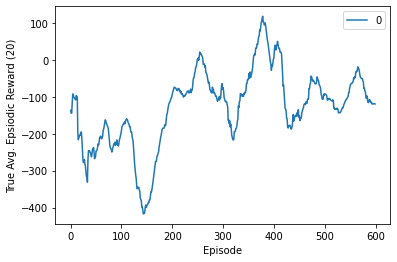

total time: 1864.0210223197937 s


In [22]:
run(total_trials=1, total_episodes=600, gamma=0.999, buffer_capacity=200000, tau=0.0005, critic_lr=0.0001, 
    actor_lr=0.00005, start_steps=1000, continuous=False, epsilon_func=decreasing_eps)

In [ ]:
run(total_trials=1, total_episodes=1000, gamma=0.996, buffer_capacity=200000, tau=0.0005, critic_lr=0.0001, 
    actor_lr=0.00005, start_steps=1000, continuous=False, epsilon_func=decreasing_eps)

Ep 0 * AvgReward -136.86 * true AvgReward -136.86 * Reward -136.86 * True Reward -136.86 * time 1.18 * step 81
Ep 1 * AvgReward -144.18 * true AvgReward -144.18 * Reward -151.49 * True Reward -151.49 * time 0.49 * step 157
Ep 2 * AvgReward -144.49 * true AvgReward -144.49 * Reward -145.11 * True Reward -145.11 * time 0.46 * step 229
Ep 3 * AvgReward -119.67 * true AvgReward -119.67 * Reward -45.21 * True Reward -45.21 * time 0.46 * step 299
Ep 4 * AvgReward -92.41 * true AvgReward -92.41 * Reward 16.64 * True Reward 16.64 * time 0.52 * step 377
Ep 5 * AvgReward -92.87 * true AvgReward -92.87 * Reward -95.20 * True Reward -95.20 * time 0.38 * step 433
Ep 6 * AvgReward -100.00 * true AvgReward -100.00 * Reward -142.75 * True Reward -142.75 * time 0.53 * step 516
Ep 7 * AvgReward -102.90 * true AvgReward -102.90 * Reward -123.19 * True Reward -123.19 * time 0.47 * step 585
Ep 8 * AvgReward -103.94 * true AvgReward -103.94 * Reward -112.32 * True Reward -112.32 * time 0.39 * step 643
Ep 9 

Ep 73 * AvgReward -256.70 * true AvgReward -256.70 * Reward -335.93 * True Reward -335.93 * time 0.95 * step 5683
Ep 74 * AvgReward -269.01 * true AvgReward -269.01 * Reward -467.95 * True Reward -467.95 * time 1.02 * step 5810
Ep 75 * AvgReward -280.77 * true AvgReward -280.77 * Reward -401.92 * True Reward -401.92 * time 1.14 * step 5944
Ep 76 * AvgReward -281.70 * true AvgReward -281.70 * Reward -217.39 * True Reward -217.39 * time 1.03 * step 6069
Ep 77 * AvgReward -288.33 * true AvgReward -288.33 * Reward -307.67 * True Reward -307.67 * time 0.63 * step 6143
Ep 78 * AvgReward -286.70 * true AvgReward -286.70 * Reward -232.95 * True Reward -232.95 * time 0.51 * step 6205
